In [1]:
from sklearn.datasets import load_files
from sklearn.metrics import matthews_corrcoef, f1_score, accuracy_score
from sklearn.metrics import precision_score, recall_score
from keras.utils import np_utils, plot_model
from keras.preprocessing import image                  
from keras.models import Model
from keras.layers import Dense, Flatten, Input
from keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import optimizers
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7099087964230269153, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 5999729076594516759
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 6132387473628956298
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11330115994
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 6389734422457533859
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!cp -r '/content/drive/My Drive/Colab Notebooks/spectograms.zip' /content/

In [5]:
!unzip /content/spectograms.zip;

Archive:  /content/spectograms.zip
  inflating: Data/train_spectograms/pd_negative/4968.png  
  inflating: Data/train_spectograms/pd_negative/3961.png  
  inflating: Data/train_spectograms/pd_negative/6831.png  
  inflating: Data/train_spectograms/pd_negative/412.png  
  inflating: Data/train_spectograms/pd_negative/5486.png  
  inflating: Data/train_spectograms/pd_negative/374.png  
  inflating: Data/train_spectograms/pd_negative/6825.png  
  inflating: Data/train_spectograms/pd_negative/1179.png  
  inflating: Data/train_spectograms/pd_negative/6616.png  
  inflating: Data/train_spectograms/pd_negative/2470.png  
  inflating: Data/train_spectograms/pd_negative/8161.png  
  inflating: Data/train_spectograms/pd_negative/8175.png  
  inflating: Data/train_spectograms/pd_negative/1151.png  
  inflating: Data/train_spectograms/pd_negative/3746.png  
  inflating: Data/train_spectograms/pd_negative/7911.png  
  inflating: Data/train_spectograms/pd_negative/638.png  
  inflating: Data/train_

In [0]:
def load_dataset(path):
    data = load_files(path)
    spectogram_files = np.array(data['filenames'])
    spectogram_targets = np_utils.to_categorical(np.array(data['target']))
    return spectogram_files, spectogram_targets

In [0]:
train_files, train_targets = load_dataset('/content/Data/train_spectograms/')
valid_files, valid_targets = load_dataset('/content/Data/valid_spectograms/')

In [0]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path)
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [9]:
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255

100%|██████████| 525/525 [00:00<00:00, 546.83it/s]


In [0]:
learning_rate = 0.005
train_epochs=100

In [0]:
def cnn_model():
    # Define the network
    image_input = Input(shape=(224, 224, 3))
    pretrained_model = VGG16(weights='imagenet', include_top=False, input_tensor=image_input)

    last_layer = pretrained_model.get_layer('block5_pool').output
    x= Flatten(name='flatten')(last_layer)
    x = Dense(128, activation='relu', name='fc1')(x)
    x = Dense(128, activation='relu', name='fc2')(x)
    out = Dense(2, activation='softmax', name='output')(x)
    custom_model = Model(image_input, out)
    
    for layer in custom_model.layers[:-3]:
        layer.trainable = False
    
    custom_model.compile(optimizer=optimizers.SGD(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return custom_model

In [12]:
model = cnn_model()
plot_model(model, '/content/model_transfer_learning.png', show_shapes=True)
model.summary()

W0905 12:07:40.082085 140030180112256 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0905 12:07:40.086070 140030180112256 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0905 12:07:40.098722 140030180112256 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0905 12:07:40.130779 140030180112256 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4267: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



58892288/58889256 [==============================] - 2s 0us/step


W0905 12:07:43.366679 140030180112256 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0905 12:07:43.371508 140030180112256 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:197: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0905 12:07:44.028580 140030180112256 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [13]:
checkpointer = ModelCheckpoint(filepath='/content/saved_weights_transfer_learning.hdf5', 
                               verbose=1, save_best_only=True)

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, 
                           verbose=1, mode='auto')

model.fit(train_tensors, train_targets, validation_data=(valid_tensors, valid_targets),
          epochs=train_epochs, batch_size=32, callbacks=[checkpointer, early_stop], verbose=1)

W0905 12:07:44.535733 140030180112256 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 2100 samples, validate on 525 samples
Epoch 1/100
2100/2100 [==============================] - 32s 15ms/step - loss: 0.4394 - acc: 0.7919 - val_loss: 0.3817 - val_acc: 0.8038

Epoch 00001: val_loss improved from inf to 0.38173, saving model to /content/saved_weights_transfer_learning.hdf5
Epoch 2/100
2100/2100 [==============================] - 24s 12ms/step - loss: 0.3533 - acc: 0.8343 - val_loss: 0.3356 - val_acc: 0.8629

Epoch 00002: val_loss improved from 0.38173 to 0.33563, saving model to /content/saved_weights_transfer_learning.hdf5
Epoch 3/100
2100/2100 [==============================] - 24s 12ms/step - loss: 0.3318 - acc: 0.8486 - val_loss: 0.3201 - val_acc: 0.8305

Epoch 00003: val_loss improved from 0.33563 to 0.32014, saving model to /content/saved_weights_transfer_learning.hdf5
Epoch 4/100
2100/2100 [==============================] - 24s 12ms/step - loss: 0.3170 - acc: 0.8567 - val_loss: 0.3468 - val_acc: 0.8438

Epoch 00004: val_loss did not improve from 0.32014


In [0]:
model.load_weights('/content/saved_weights_transfer_learning.hdf5')

In [0]:
valid_pred_real = model.predict(valid_tensors)
valid_pred = np_utils.to_categorical([np.argmax(prediction) for prediction in valid_pred_real])


In [16]:
score_acc = accuracy_score(valid_targets, valid_pred)
score_f1 = f1_score(valid_targets, valid_pred, average='macro')
score_prec = precision_score(valid_targets, valid_pred, average='macro')
score_rec = recall_score(valid_targets, valid_pred, average='macro')
score_mcc = matthews_corrcoef(valid_targets.argmax(axis=1), valid_pred.argmax(axis=1))

print("accuracy for validation data is = {:.4f}".format(score_acc))
print("F1 score for validation data is = {:.4f}".format(score_f1))
print("precision for validation data is = {:.4f}".format(score_prec))
print("recall for validation data is = {:.4f}".format(score_rec))
print("MCC for validation data is = {:.4f}".format(score_mcc))



accuracy for validation data is = 0.9086
F1 score for validation data is = 0.8529
precision for validation data is = 0.8584
recall for validation data is = 0.8477
MCC for validation data is = 0.7060


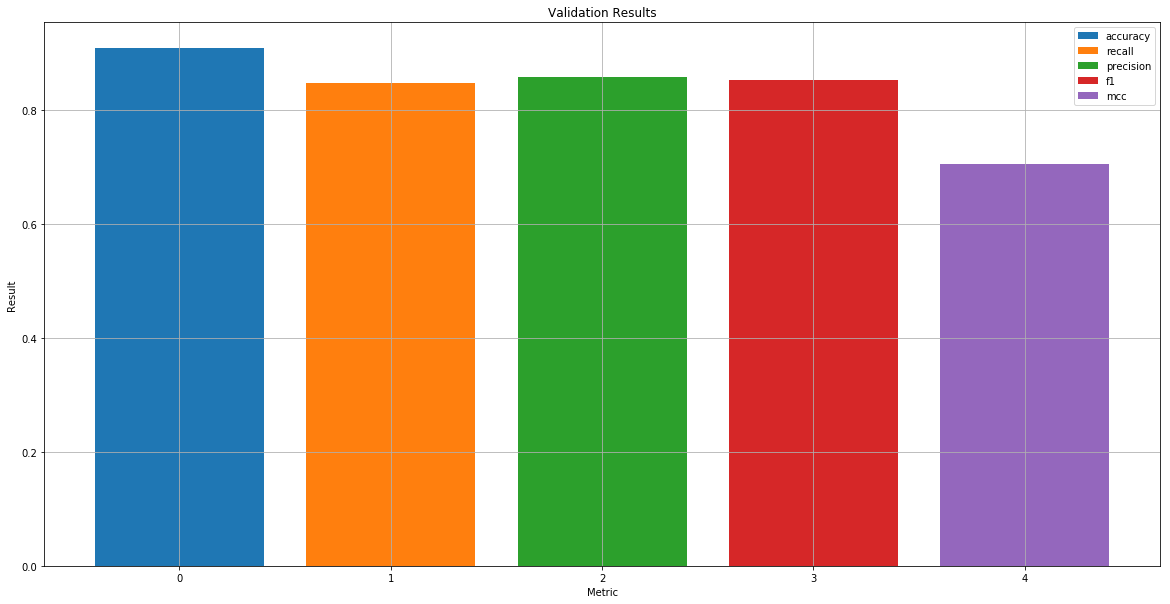

In [17]:
fig, ax1 = plt.subplots(figsize=(20, 10))
ax1.bar(0, score_acc)
ax1.bar(1, score_rec)
ax1.bar(2, score_prec)
ax1.bar(3, score_f1)
ax1.bar(4, score_mcc)
ax1.set(xlabel='Metric', ylabel='Result', title='Validation Results')
ax1.legend(['accuracy', 'recall', 'precision', 'f1', 'mcc'])
ax1.grid()
plt.show();

In [0]:
!rm -r '/content/Data'
!rm -r '/content/spectograms.zip'

In [0]:
!cp '/content/saved_weights_transfer_learning.hdf5' '/content/drive/My Drive/Colab Notebooks/'
!cp '/content/model_transfer_learning.png' '/content/drive/My Drive/Colab Notebooks/'